In [1]:
import pandas as pd
import seaborn as sns
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from foolbox.econometrics.misc import descriptives
from foolbox.backtesting.sorting import rank_sort

from src.setup import *

from src.datafeed_.kraken.downstream import (get_funding_rate, 
                                             get_spot, 
                                             get_perpetual)

# pandas display settings
pd.set_option("display.precision", 2)

In [2]:
# parameters
t_hold = 1  # holding period, in multiples of a 4-hour period
ann = 365 * 6  # there are 6 4-hour periods per day
legsize = 2  # leg size
signal_lookback = 6 * 7  # 7 days lookback to compute carry signal

In [3]:
# carry is the negative of the relative funding rate, ~(spot / fwd - 1)
data_f = get_funding_rate()

carry = data_f \
    .query("rate == 'relative'").drop("rate", axis=1) \
    .set_index("timestamp") \
    .mul(-1)

<AxesSubplot:xlabel='asset'>

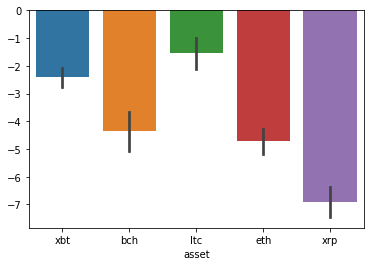

In [4]:
# plot
sns.barplot(data=carry * ann * 100)

In [5]:
# print descriptives (some are meaningless)
carry_d = descriptives(carry, ann=ann, scl=100, cov_lags=30)
print(carry_d)

asset       xbt      bch      ltc      eth      xrp
mean      -2.41    -4.36    -1.55    -4.73    -6.93
sterr      0.73     1.32     1.20     0.89     0.97
tstat     -3.30    -3.30    -1.29    -5.31    -7.16
median    -1.54    -5.75    -2.06    -4.54    -5.33
std        0.31     0.63     0.51     0.41     0.50
dstd       0.24     0.39     0.32     0.29     0.39
q95       18.70    41.86    39.02    25.20    24.71
q05      -26.95   -42.01   -35.72   -33.62   -45.65
skew      -0.02     1.14     0.94     0.53    -0.05
kurt       6.91     7.12     6.36     7.38     6.11
sharpe    -7.75    -6.97    -3.05   -11.51   -13.93
ac1        0.77     0.74     0.81     0.75     0.72
count   7133.00  7133.00  7133.00  7133.00  7133.00
maxdd     11.76    21.46    14.17    19.27    22.56


In [6]:
# the signal is the rolling median
carry_sig = carry\
    .rolling(signal_lookback, min_periods=signal_lookback // 2)\
    .median()\
    .shift(1)

# portfolio sorts
sorts = rank_sort(carry_sig, legsize=legsize)

print(sorts[["p_low", "p_high"]].tail(6))

/home/ipozdeev/projects/python-packages/foolbox/backtesting/sorting.py:198: RuntimeWarning: invalid value encountered in true_divide
  bins = (np.array(nass)/n_assets+epsilon).cumsum()


portfolio                 p_low                     p_high                    
asset                       xbt  bch  ltc  eth  xrp    xbt  bch  ltc  eth  xrp
timestamp                                                                     
2021-12-01 12:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-01 16:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-01 20:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 00:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 04:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 08:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0


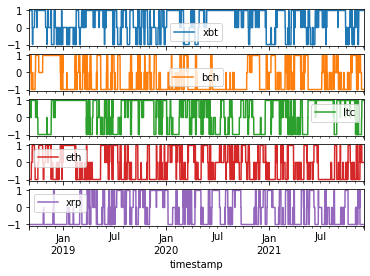

In [7]:
# plot positions
ax = sorts["p_high"].add(sorts["p_low"].mul(-1)).plot(subplots=True)

In [8]:
# spot prices
data_s = get_spot()\
    .resample("4H", closed="right", label="right").last()\
    .loc["2018-08-31":]
print(data_s.tail(6))

                              bch      eth      xbt   xrp     ltc
timestamp                                                        
2021-03-31 04:00:00+00:00  524.64  1826.01  58750.0  0.55  193.43
2021-03-31 08:00:00+00:00  514.51  1808.49  58026.8  0.55  190.91
2021-03-31 12:00:00+00:00  517.27  1814.88  58141.3  0.55  191.23
2021-03-31 16:00:00+00:00  521.93  1844.97  58999.9  0.55  192.01
2021-03-31 20:00:00+00:00  535.09  1940.01  58968.7  0.56  195.64
2021-04-01 00:00:00+00:00  541.08  1918.89  58786.2  0.57  196.81


Text(0.5, 0, '')

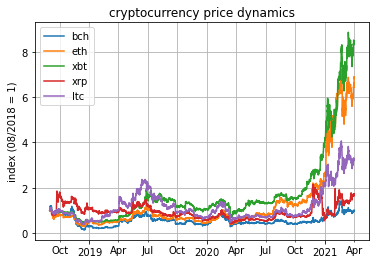

In [9]:
# plot spot price index
spot_idx = data_s.div(data_s.iloc[0], axis=1)
ax = sns.lineplot(data=spot_idx, dashes=False)

# formatting
ax.set_xticks(
    pd.period_range("2018-09", "2021-03", freq="6M").to_timestamp()
)
ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))

ax.grid(which="both")

ax.set_title("cryptocurrency price dynamics")

ax.set_ylabel("index (08/2018 = 1)")
ax.set_xlabel("", visible=False)

In [10]:
# perpetual futures prices
data_p = get_perpetual(mid=True) \
    .resample("4H", closed="right", label="right").last()

print(data_p.tail(6))

asset                       xrp       xbt     ltc      eth     bch
timestamp                                                         
2021-02-28 04:00:00+00:00  0.42  44662.00  158.43  1368.42  458.40
2021-02-28 08:00:00+00:00  0.41  44479.50  159.19  1343.05  451.50
2021-02-28 12:00:00+00:00  0.42  45353.00  163.86  1371.83  461.60
2021-02-28 16:00:00+00:00  0.40  43380.00  155.20  1317.92  441.55
2021-02-28 20:00:00+00:00  0.41  44466.00  162.96  1393.05  453.30
2021-03-01 00:00:00+00:00  0.42  45259.25  164.64  1422.75  460.50


In [11]:
# forward-looking returns and funding (levered x2)
# need 1 long and 3 short contracts to achieve the same level of leverage
n_long = 1
n_short = 3

# absolute funding rate
data_f = get_funding_rate() \
    .query("rate == 'absolute'").drop("rate", 1) \
    .set_index("timestamp")

# long
r_long = n_long * data_s.shift(-t_hold) * \
     (1 / data_p - 1 / data_p.shift(-t_hold) -
      data_f.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
     data_s.shift(-t_hold) / data_s - 1

r_short = n_short * data_s.shift(-t_hold) * \
      (1 / data_p.shift(-t_hold) - 1 / data_p +
       data_f.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
      data_s.shift(-t_hold) / data_s - 1

rx = pd.concat([r_long, r_short], axis=1, keys=["p_high", "p_low"],
               names=["portfolio", "asset"])

/tmp/ipykernel_6601/2706435654.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_f = get_funding_rate() \


In [12]:
# take a look at returns
print("p_high (x2 leverage):")
print(descriptives(rx.xs("p_high", axis=1), ann=ann/t_hold, scl=100))
print("\np_low (x2 leverage):")
print(descriptives(rx.xs("p_low", axis=1), ann=ann/t_hold, scl=100))

p_high (x2 leverage):
asset        bch       eth       ltc      xbt       xrp
mean       90.79    194.22    165.43   192.60    104.68
sterr     135.36    111.79    118.61    87.55    130.10
tstat       0.67      1.74      1.39     2.20      0.80
median   -140.94     98.31     -3.38   117.37    -58.53
std       206.17    171.73    180.08   133.22    200.82
dstd      162.52    139.54    136.61   112.70    155.94
q95     13759.14  12232.53  12754.41  9687.95  12039.02
q05    -13402.43 -11635.23 -12437.93 -8405.22 -11512.41
skew       -0.22     -0.70     -0.16    -0.86      0.75
kurt       17.10     11.96      7.94    19.05     32.19
sharpe      0.44      1.13      0.92     1.45      0.52
ac1         0.08      0.06      0.08     0.08      0.05
count    5470.00   5471.00   5471.00  5471.00   5471.00
maxdd     369.58    232.23    263.92   179.31    255.79

p_low (x2 leverage):
asset        bch       eth       ltc       xbt       xrp
mean      -41.96   -152.93   -143.62   -170.48    -35.50
st

In [13]:
# sort returns into portfolios according to the signal
res_hl = rx.mul(sorts / legsize) \
    .groupby(axis=1, level="portfolio").sum(min_count=1) \
    .loc[:, ["p_high", "p_low"]].dropna()

# high minus low
res_hl.insert(0, "p_hml", res_hl.eval("p_high + p_low"))

print(res_hl.tail(6))

portfolio                     p_hml    p_high  p_low
timestamp                                           
2021-02-28 00:00:00+00:00 -1.19e-02 -1.01e-01   0.09
2021-02-28 04:00:00+00:00  3.39e-02 -2.78e-03   0.04
2021-02-28 08:00:00+00:00 -4.98e-02  1.29e-02  -0.06
2021-02-28 12:00:00+00:00  3.35e-02 -7.57e-02   0.11
2021-02-28 16:00:00+00:00 -1.81e-02  6.76e-02  -0.09
2021-02-28 20:00:00+00:00 -5.16e-03  2.81e-02  -0.03


In [14]:
rx_d = descriptives(res_hl, ann=(ann / t_hold), scl=100)

print(rx_d)

portfolio     p_hml    p_high     p_low
mean         232.38    221.64     10.74
sterr         93.06    107.98    126.90
tstat          2.50      2.05      0.08
median       275.76    142.38     90.91
std          177.04    164.40    218.09
dstd         133.89    135.56    156.76
q95        11653.77  11300.31  14879.16
q05       -12061.35 -10869.14 -15007.17
skew           0.47     -0.71      0.78
kurt          13.21     16.77     13.16
sharpe         1.31      1.35      0.05
ac1           -0.31      0.07     -0.16
count       5453.00   5453.00   5453.00
maxdd        114.51    252.46    373.85


Text(0, 0.5, 'payoff w/o reinvestment, in USD')

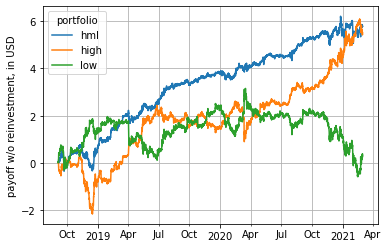

In [19]:
# plot
to_plot = res_hl.cumsum()\
    .rename(columns=lambda x: x[2:])\
    .reset_index().melt(id_vars=["timestamp"], value_name="payoff")
ax = sns.lineplot(x="timestamp", y="payoff", data=to_plot, hue="portfolio")

ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))
ax.grid(True, which="both")

ax.set_xlabel("", visible=False)
ax.set_ylabel("payoff w/o reinvestment, in USD")